In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time
%matplotlib inline

## FIRST, LETS CONSTRUCT THE FEASIBLE-SOLUTION (FSA) ALGORITH
* Implementation is based on 
* Douglas M. Hawkins, 1992

In [188]:
# currently support for np.ndarray and matrix
def validate(X, y, h_size, use_intercept):
    if X is None or not isinstance(X, (np.ndarray, np.matrix)):
        raise Exception('X must be  type array or np.ndarray or np.matrix')
    if y is None or not isinstance(y, (np.ndarray, np.matrix)):
        raise Exception('y must be  type array or np.ndarray or np.matrix')

    if X.ndim == 1:
        X = np.reshape(X, [X.shape[0], 1])
    if y.ndim == 1:
        y = np.reshape(y, [y.shape[0], 1])

    if type(X) is not np.matrix:
        X = np.asmatrix(X)
    if type(y) is not np.matrix:
        y = np.asmatrix(y)

    if y.ndim != 1:
        if y.ndim != 2 or y.shape[1] != 1:
            raise ValueError('y must be 1D array')
    if y.shape[0] != X.shape[0]:
        raise ValueError('X and y must have same number of samples')

    if X.shape[0] < 1:  # expects N >= 1
        raise ValueError('You must provide at least one sample')

    if X.ndim < 1:  # expects p >=1
        raise ValueError('X has zero dimensions')

    if h_size != 'default':
        if h_size > X.shape[0]:
            raise ValueError('H_size must not be > number of samples')
        if h_size < 1:
            raise ValueError('H_size must be > 0 ; preferably (n + p + 1) / 2 <= h_size <= n ')

    if use_intercept:
        merged = np.concatenate([y, X, np.ones((X.shape[0], 1))], axis=1)
    else:
        merged = np.concatenate([y, X], axis=1)

    return np.asmatrix(merged)


# for storage only
class Result:
    def __init__(self, theta_hat, h_index, rss, steps):
        self.theta_hat = theta_hat
        self.h_index = h_index
        self.rss = rss
        self.steps = steps
        
class FSARegression:
    def __init__(self):
        self._data = None
        self._p = None
        self._N = None
        self._h_size = None
        # public
        self.n_iter_ = None
        self.coef_ = None
        self.intercept_ = None
        self.h_subset_ = None
        self.rss_ = None       
        
    def fit(self, X, y,
            num_starts: 'number of initial starts (H1)' = 10,
            h_size: 'default := (n + p + 1) / 2' = 'default',
            use_intercept=True):

        # Init some properties
        self._data = validate(X, y, h_size, use_intercept)
        
        self._p = self._data.shape[1] - 1
        self._N = self._data.shape[0]

        if h_size == 'default':
            self._h_size = math.ceil((self._N + self._p + 1) / 2)  # todo with or without intercept?
        else:
            self._h_size = h_size
            
            
        self.x_all = self._data[:, 1:]
        self.y_all = self._data[:, [0]]
            
        results = []
        
        # for all initial starts
        for i in range(num_starts):
            
            # generate random subset J, |J| = h and its complement M 
            idx_initial, idx_rest = self.select_initial_h1()
            # save splitted data
            J = np.matrix(self._data[idx_initial], copy=True)
            M = np.matrix(self._data[idx_rest], copy=True)
            # do the refinement process
            res = self.refinement_process(J, M, idx_initial, idx_rest)
                    
            # store the results
            results.append(res)
            
        # select best results
        best_result = results[0]
        for res in results:
            if res.rss < best_result.rss:
                best_result = res
            
        
         # ... Store results
        theta_final = best_result.theta_hat
        
        if use_intercept:
            self.intercept_ = theta_final[-1,0]  # last row last col
            self.coef_ = theta_final[:-1,0]  # for all but last row,  only first col
        else:
            self.intercept_ = 0.0
            self.coef_ = theta_final[:,0]  # all rows, only first col

        self.h_subset_ = best_result.h_index
        self.rss_ = best_result.rss
        self.steps_ = best_result.steps
        
        self.coef_ = np.ravel(self.coef_) # RAVELED
        
    def go_through_all_pairs(self, J, M, inversion, residuals_J, residuals_M, idx_initial, residuals_all):
        delta = 1
        i_to_swap = None
        j_to_swap = None
        
        # go through all combinations
        for i in range(J.shape[0]):
            for j in range(M.shape[0]):
                #. calculate deltaRSS
                tmp_delta = self.calculate_delta_rss(J, M, inversion, residuals_J, residuals_M, i, j, idx_initial, residuals_all)
                # if delta rss < bestDeltaRss
                if tmp_delta < 0 and tmp_delta < delta:
                    delta = tmp_delta
                    i_to_swap = i
                    j_to_swap = j
                    
        return i_to_swap, j_to_swap, delta
                        
    def refinement_process(self, J, M, idx_initial, idx_rest):
        theta = None 
        steps = 0
        
        while(True):
            
            # data for delata eqation
            y = J[:, [0]]
            x = J[:, 1:]
            inversion = (x.T * x).I
            theta = inversion * x.T * y # OLS
            residuals_J = y - x * theta
            residuals_M = (M[:, [0]]) - (M[:, 1:]) * theta
            #residuals_all = self.y_all - self.x_all *theta
            residuals_all = None
            # vector_residulas_all = self.y_all - self.x_all * theta # non squared residual vector [ON ALL CASES!]
            
            i_to_swap, j_to_swap, delta = self.go_through_all_pairs(J, M, inversion, residuals_J, residuals_M, idx_initial, residuals_all)
            # if bestRess >= 0 : break
            
            if delta >= 0:
                break            
            else: # swap i and j [TOGHETHER WITH INDEXES] ; je to ok - SWAPUJEME SPRAVNE            
                tmp = np.copy( J[i_to_swap] ) 
                J[i_to_swap] = np.copy( M[j_to_swap] )
                M[j_to_swap] = np.copy( tmp )
                idx_initial[i_to_swap], idx_rest[j_to_swap] = idx_rest[j_to_swap], idx_initial[i_to_swap]
                steps +=1
            # END WHILE
        ############################################
            
        # one done
        # finally calculate RSS
        y_fin = J[:, [0]]
        x_fin = J[:, 1:]
        rss = (y_fin - x_fin * theta).T * (y_fin - x_fin * theta)
        
        rss = rss[0,0]
        # uloz soucasny_set == theta, h_index, rss
        return Result(theta, idx_initial, rss, steps)
      
    def calculate_delta_rss(self, J, M, inversion, residuals_J, residuals_M, i, j, idx_initial, residuals_all):
        # both are vaild
        eiJ = residuals_J[i, 0]
        ejJ = residuals_M[j, 0]
        #eiJ_bad = residuals_all[idx_initial[i]]
        #ejJ_bad = residuals_all[idx_initial[j]]
        
        hii = J[i,1:] * inversion * (J[i,1:]).T
        hij = J[i,1:] * inversion * (M[j,1:]).T
        hjj = M[j,1:] * inversion * (M[j,1:]).T
        hii = hii[0,0]
        hij = hij[0,0]
        hjj = hjj[0,0]
        
        nom = (ejJ * ejJ * (1 - hii) ) - ( eiJ * eiJ * (1 + hjj)) + 2*eiJ*ejJ*hij
        
        denom = (1 - hii)*(1 + hjj) + hij * hij
        return nom/denom
    
        # Select initial H1
    def select_initial_h1(self):

        # create random permutation
        idx_all = np.random.permutation(self._N)
        
        # cut first h indexes and save the rest
        idx_initial = idx_all[:self._h_size]
        idx_rest = idx_all[self._h_size:]
        
        return idx_initial, idx_rest

## Now, lets generate some data

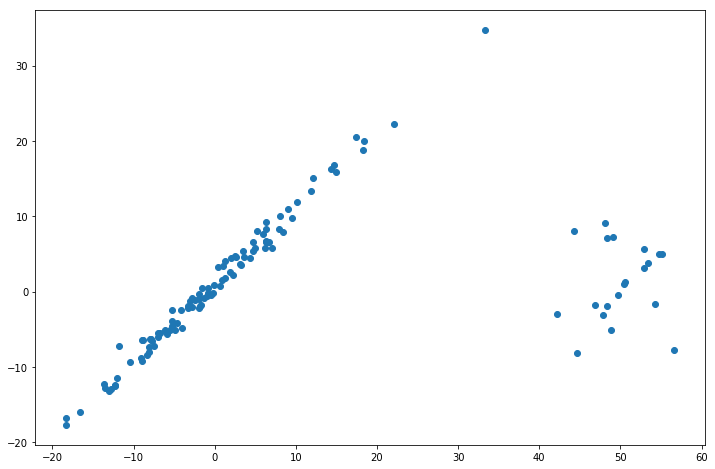

In [189]:
# LINEAR DATA
# data generated same way as in Rousseeuw and Driessen 2000
X_original = np.random.normal(loc=0,scale=10, size=100) # var = 100
e = np.random.normal(loc=0,scale=1, size=100) # var = 1
y_original = 1 + X_original + e

# OUTLIERS
# multivariate N(mean = location, covariance)
# diagonalni 25 I
outliers = np.random.multivariate_normal(mean = [50, 0], 
                                         cov = [[25, 0], [0, 25]], 
                                         size=20)

# FINAL DATA
X = np.concatenate((X_original,outliers.T[0]), axis=0)
y = np.concatenate((y_original,outliers.T[1]), axis=0)

plt.figure(figsize=(12,8))
plt.scatter(x=X, y=y)

## And now, lets test our algorithm

One done
One done
One done
One done
One done
One done
One done
One done
One done
One done
wights:  [0.99218716]
intercept:  0.44043449490570225
rss:  14.555447826628479
stpes: 28


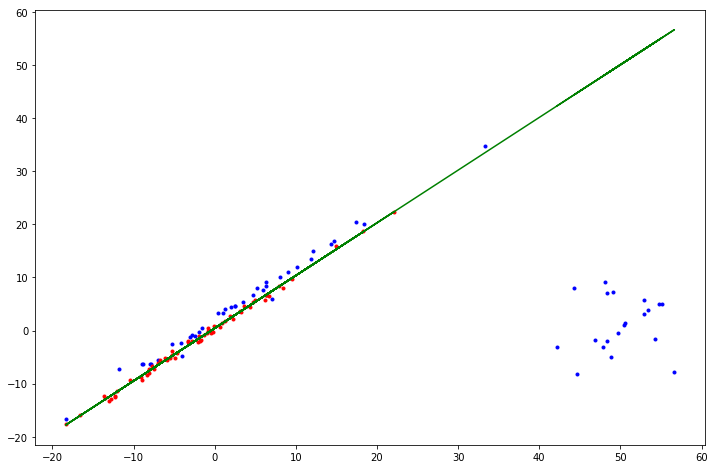

In [190]:
lts_fsa = FSARegression()
lts_fsa.fit(X, y, use_intercept=True, num_starts=10)

print('wights: ', lts_fsa.coef_)
print('intercept: ', lts_fsa.intercept_)
print('rss: ', lts_fsa.rss_)
print('stpes:', lts_fsa.steps_)  # final inters only...
arr_idx = lts_fsa.h_subset_

# Plot data
y_used = y[arr_idx]
X_used = X[arr_idx]
# nifty trick
mask = np.ones(y.shape[0], np.bool)
mask[arr_idx] = 0
y_not_used = y[mask]
X_not_used = X[mask]

# Pot itself
plt.figure(figsize=(12, 8))
plt.plot(X_not_used, y_not_used, 'b.')
plt.plot(X_used, y_used, 'r.')

tmp =  ( lts_fsa.coef_ * X + lts_fsa.intercept_)
#tmp = np.ravel(tmp)

plt.plot(X, tmp, '-g')
plt.show()